<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20CWRU%20Dataset%20250616.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [ ]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/240.mat


<ipython-input-5-4247073321>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['240']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/99.mat
['240' '99']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/215.mat
['240' '99' '215']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/191.mat
['240' '99' '215' '191']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/111.mat
['240' '99' '215' '191' '111']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/203.mat
['240' '99' '215' '191' '111' '203']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/137.mat
['240' '99' '215' '191' '111' '203' '137']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/124.mat
['240' '99' '215' '191' '111' '203' '137' '124']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/228.mat
['240' '99' '215' '191' '111' '203' '137' '124' '228']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2/176.mat
['240' '99' '215' '191' '111' '203' '137' '124' '228' '176']


# Multi-Kernel Deep 1D-CNN

In [ ]:
pip install tensorflow

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2437, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 2437, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 2437, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2238, 64)  │     12,864 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2338, 64)  │      6,464 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 2388, 64)  │      3,264 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2238, 64)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2338, 64)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2388, 64)  │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 111, 64)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 233, 64)   │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 477, 64)   │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7104)      │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 14912)     │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 30528)     │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 52544)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │  5,254,500 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9)         │        909 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,278,001 (20.13 MB)

 Trainable params: 5,278,001 (20.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 582ms/step - accuracy: 0.1368 - loss: 4.0158 - val_accuracy: 0.3487 - val_loss: 3.1625
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4141 - loss: 3.1154 - val_accuracy: 0.4347 - val_loss: 2.7521
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5552 - loss: 2.4977 - val_accuracy: 0.6454 - val_loss: 2.4139
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6962 - loss: 2.3702 - val_accuracy: 0.7329 - val_loss: 2.2642
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7648 - loss: 2.2591 - val_accuracy: 0.7448 - val_loss: 2.1510
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8302 - loss: 2.1575 - val_accuracy: 0.7760 - val_loss: 2.0926
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8534 - loss: 1.8634 - val_accuracy: 0.8071 - val_loss: 2.0051
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8775 - loss: 1.7943 - val_accuracy: 0.8056 -

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


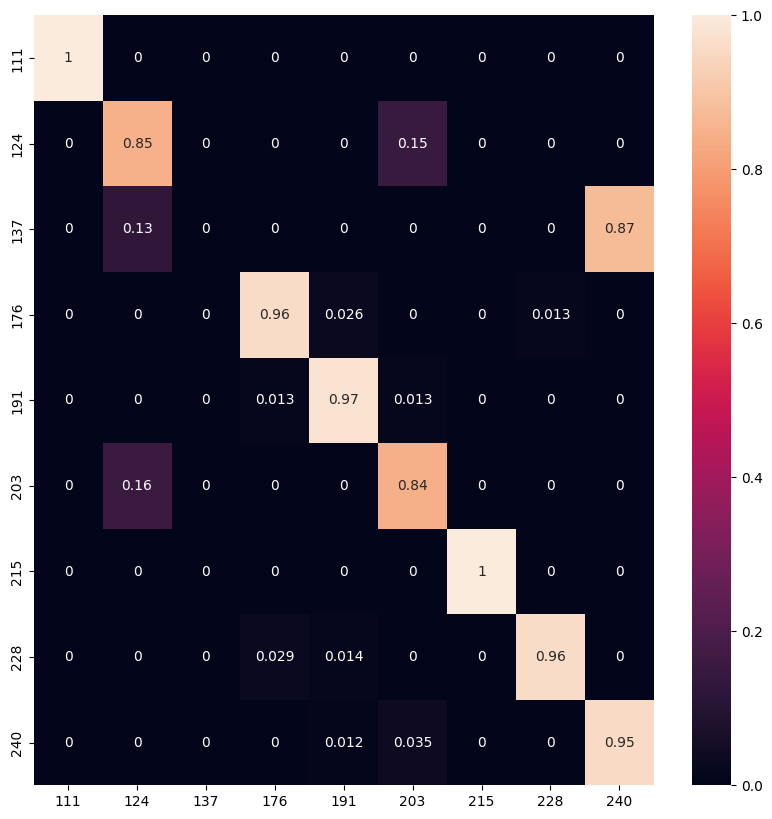

In [ ]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [ ]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...
[t-SNE] Computed neighbors for 1570 samples in 0.126s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 4.337503
[t-SNE] Computed conditional probabilities in 0.077s
[t-SNE] Iteration 50: error = 57.8884087, gradient norm = 0.0362623 (50 iterations in 0.595s)
[t-SNE] Iteration 100: error = 53.5238419, gradient norm = 0.0138204 (50 iterations in 0.447s)
[t-SNE] Iteration 150: error = 52.5670815, gradient norm = 0.0070926 (50 iterations in 0.687s)
[t-SNE] Iteration 200: error = 52.1328697, gradient norm = 0.0057490 (50 iterations in 0.680s)
[t-SNE] Iteration 250: error = 51.8770447, gradient norm = 0.0076419 (50 iterations in 0.661s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.877045
[t-SNE] Iteration 300: error = 0.9221562, gradient norm = 0.0180187 (50 iterations in 0.675s

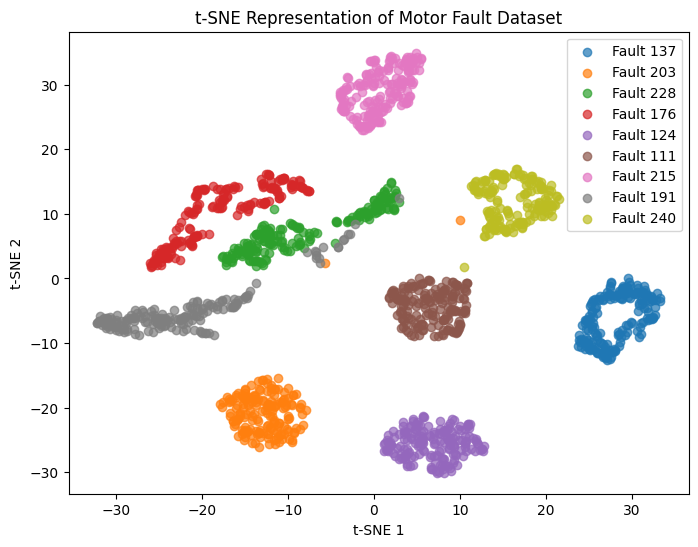

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [ ]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2437, STRIDE: 1949
Extracted 2244 rows (target: 1800)
     fault  window      mean       std       rms       max       min  \
0      240       1  0.015607  0.492382  0.492629  3.210128 -3.966336   
1      240       2  0.015350  0.646707  0.646889  4.917856 -4.585659   
2      240       3  0.014072  0.669473  0.669621  3.917091 -4.262643   
3      240       4  0.014014  0.701110  0.701250  3.917091 -4.262643   
4      240       5  0.014971  0.529179  0.529391  3.437992 -4.165821   
...    ...     ...       ...       ...       ...       ...       ...   
2239   176     246  0.013869  0.293245  0.293573  1.901788 -1.770328   
2240   176     247  0.015376  0.296763  0.297161  1.901788 -1.770328   
2241   176     248  0.016397  0.318915  0.319336  2.213536 -2.146763   
2242   176     249  0.018091  0.123074  0.124397  0.709049 -0.772901   
2243   176     250  0.016510  0.203745  0.204413  1.365097 -1.342979   

      skewness   kurtosis  form_factor  crest_factor  
0 

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
215    251
240    250
176    250
203    249
191    249
124    249
137    249
228    249
111    248
Name: count, dtype: int64
Current rows after equal resampling: 1566
New class distribution:
fault
111    175
137    175
228    175
191    175
124    174
203    174
176    174
240    174
215    174
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [ ]:
balanced_df.shape

(1570, 11)

In [ ]:
balanced_df=balanced_df.sort_values(by='fault')

In [ ]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,111,142,0.017201,0.284272,0.284792,1.543128,-1.460308,-0.043963,4.067017,1.429144,5.418441
1568,111,128,0.012351,0.265459,0.265746,1.291121,-1.453215,-0.045666,3.941706,1.416071,4.858474
1558,111,36,0.016900,0.270977,0.271503,1.566076,-1.365388,0.186171,5.532504,1.476498,5.768163
44,111,5,0.015156,0.289498,0.289894,1.524770,-1.590066,-0.045045,4.452422,1.450048,5.259742
1556,111,157,0.016559,0.285970,0.286449,1.521223,-1.304472,0.184899,4.231253,1.448151,5.310621
...,...,...,...,...,...,...,...,...,...,...,...
373,240,71,0.018764,0.534298,0.534627,3.378731,-3.277736,-0.443695,9.628761,1.779096,6.319789
17,240,23,0.014437,0.432715,0.432956,2.523197,-2.816165,-0.022964,8.885359,1.679529,5.827842
424,240,146,0.012160,0.666001,0.666112,4.230091,-4.742576,-0.463338,10.695147,1.854338,6.350424
422,240,68,0.015202,0.607570,0.607760,4.381165,-5.046395,-0.677177,20.392828,2.087994,7.208710


    t-SNE 1    t-SNE 2  fault
0 -3.602815  20.583019    111
1  5.840909   8.280206    111
2  1.734964  31.483738    111
3 -9.728330  19.856316    111
4  1.410530  26.166130    111


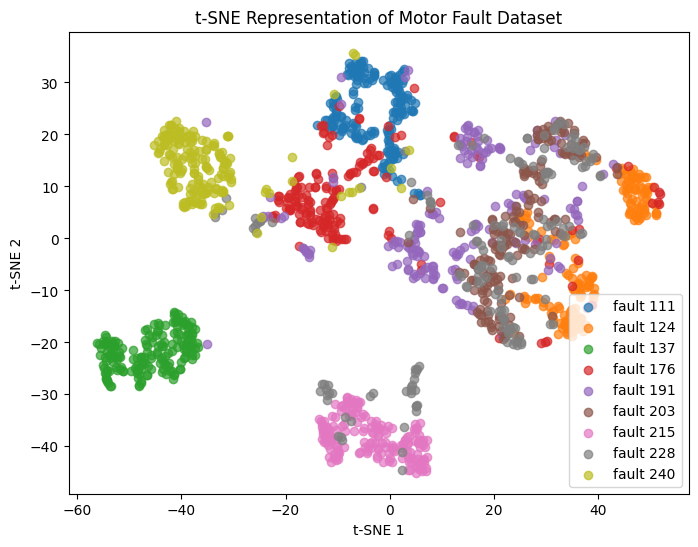

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [ ]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,-3.602815,20.583019,111
1,5.840909,8.280206,111
2,1.734964,31.483738,111
3,-9.728330,19.856316,111
4,1.410530,26.166130,111
...,...,...,...
1565,-30.531748,10.885542,240
1566,-41.859253,11.096902,240
1567,-32.347752,8.962509,240
1568,-41.315193,21.024992,240


In [ ]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,-3.602815,20.583019
1,5.840909,8.280206
2,1.734964,31.483738
3,-9.728330,19.856316
4,1.410530,26.166130
...,...,...
1565,-30.531748,10.885542
1566,-41.859253,11.096902
1567,-32.347752,8.962509
1568,-41.315193,21.024992


In [ ]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [ ]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
784,10.499080,-1.523948,111
958,3.447901,-6.582081,111
952,3.231870,-6.293106,111
951,4.341008,-6.321269,111
938,10.576126,-1.794671,111
...,...,...,...
845,15.208386,7.415153,240
838,15.116734,16.080231,240
837,19.201946,11.704128,240
1395,18.894402,14.976327,240


Combined Features

In [ ]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
784,13.013444,-3.018605,10.499080,-1.523948,111
958,19.311939,-8.441497,3.447901,-6.582081,111
952,30.968245,18.893402,3.231870,-6.293106,111
951,19.701830,3.738353,4.341008,-6.321269,111
938,35.317852,20.947247,10.576126,-1.794671,111
...,...,...,...,...,...
845,17.376198,14.137063,15.208386,7.415153,240
838,-16.674831,-1.833151,15.116734,16.080231,240
837,32.717247,-5.611972,19.201946,11.704128,240
1395,-9.245852,-38.750607,18.894402,14.976327,240


In [ ]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [ ]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [ ]:
pip install hyperactive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


Deployment:

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [08:18<00:00, 12.47s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.9928343949044587  
   Best parameter set:
      'iterations'          : 250.0  
      'depth'               : 8.0  
      'learning_rate'       : 0.05  
      'l2_leaf_reg'         : 1.0  
      'bagging_temperature' : 1.5  
      'random_strength'     : 1.0  
   Best iteration: 0  
 
   Random seed: 1198416736  
 
   Evaluation time   : 498.4077866077423 sec    [100.0 %]
   Optimization time : 0.008425712585449219 sec    [0.0 %]
   Iteration time    : 498.41621232032776 sec    [12.46 sec/iter]
 
Tuning Duration: 0:08:18.721343
Best Parameters: {'iterations': 250, 'depth': 8, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'bagging_temperature': 1.5, 'random_strength': 1}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9002807	test: 1.8969568	best: 1.8969568 (0)	total: 25.2ms	remaining: 6.27s
25:	learn: 0.3780375	test: 0.3937122	best: 0.3937122 (25)	total: 584ms	remaining: 5.03s
50:	learn: 0.1373123	test: 0.1619508	best: 0.1619508 (50)	total: 1.34s	remaining: 5.22s
75:	learn: 0.0626459	test: 0.0952297	best: 0.0952297 (75)	total: 2.07s	remaining: 4.75s
100:	learn: 0.0397064	test: 0.0771441	best: 0.0771441 (100)	total: 3.22s	remaining: 4.75s
125:	learn: 0.0280897	test: 0.0691595	best: 0.0691595 (125)	total: 4.29s	remaining: 4.22s
150:	learn: 0.0200930	test: 0.0642199	best: 0.0642199 (150)	total: 5.6s	remaining: 3.67s
175:	learn: 0.0154809	test: 0.0626641	best: 0.0626641 (175)	total: 6.18s	remaining: 2.6s
200:	learn: 0.0122644	test: 0.0615416	best: 0.0614833 (199)	total: 6.74s	remaining: 1.64s
225:	learn: 0.0102026	test: 0.0613216	best: 0.0612943 (223)	total: 7.5s	remaining: 797ms
249:	learn: 0.0085988	test: 0.0612232	best: 0.0608341 (239)	total: 8.05s	remaining: 0us

bestTest = 0.0608340971

In [ ]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [ ]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [1.9002806835382116, 1.693286782253291, 1.5147900232704263, 1.394197897748176, 1.2765488420744782, 1.1811830089339774, 1.097845687329242, 1.0225006755539856, 0.9543848076173331, 0.8993159821616346, 0.8399028380005046, 0.7873759222380647, 0.7404775876076598, 0.70208141501535, 0.6589105609668807, 0.6237685609693475, 0.5857440315858122, 0.5591827801681181, 0.5278808721682947, 0.5009657472166082, 0.47606635667388486, 0.45390064229614174, 0.43155678652013135, 0.412172377926198, 0.39566050725412405, 0.3780375067752943, 0.3601338708410512, 0.34337811200342233, 0.3278960408411944, 0.3144975226554768, 0.3007492835239262, 0.28751604886734283, 0.2756066524000114, 0.26367245104368586, 0.2525995151864771, 0.24276095815571125, 0.23204561179588662, 0.22190774425132292, 0.2136861075662945, 0.20543915252477876, 0.19665143063205195, 0.19147416767154832, 0.18413454105956067, 0.177564707288635, 0.17093023452411177, 0.16482203138472307, 0.1591680717070511, 0.1537614560580506, 0.148

In [ ]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [1.9002806835382116, 1.693286782253291, 1.5147900232704263, 1.394197897748176, 1.2765488420744782, 1.1811830089339774, 1.097845687329242, 1.0225006755539856, 0.9543848076173331, 0.8993159821616346, 0.8399028380005046, 0.7873759222380647, 0.7404775876076598, 0.70208141501535, 0.6589105609668807, 0.6237685609693475, 0.5857440315858122, 0.5591827801681181, 0.5278808721682947, 0.5009657472166082, 0.47606635667388486, 0.45390064229614174, 0.43155678652013135, 0.412172377926198, 0.39566050725412405, 0.3780375067752943, 0.3601338708410512, 0.34337811200342233, 0.3278960408411944, 0.3144975226554768, 0.3007492835239262, 0.28751604886734283, 0.2756066524000114, 0.26367245104368586, 0.2525995151864771, 0.24276095815571125, 0.23204561179588662, 0.22190774425132292, 0.2136861075662945, 0.20543915252477876, 0.19665143063205195, 0.19147416767154832, 0.18413454105956067, 0.177564707288635, 0.17093023452411177, 0.16482203138472307, 0.1591680717070511, 0.1537614560580506, 0.1483

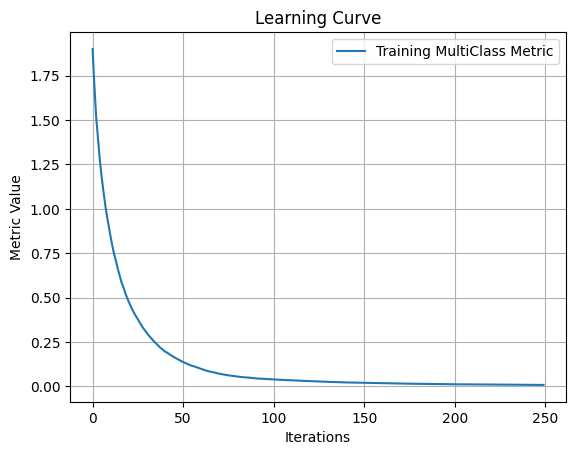

In [ ]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
              precision    recall  f1-score   support

         111       1.00      1.00      1.00       132
         124       1.00      1.00      1.00       140
         137       1.00      1.00      1.00       146
         176       1.00      1.00      1.00       135
         191       1.00      1.00      1.00       137
         203       1.00      1.00      1.00       134
         215       1.00      1.00      1.00       158
         228       1.00      1.00      1.00       144
         240       1.00      1.00      1.00       130

    accuracy                           1.00      1256
   macro avg       1.00      1.00      1.00      1256
weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
              precision    recall  f1-score   support

         111       1.00      1.00      1.00        41
         124       1.00      1.00      1.00        36
         137       1.00      1.00      1.00        32
      

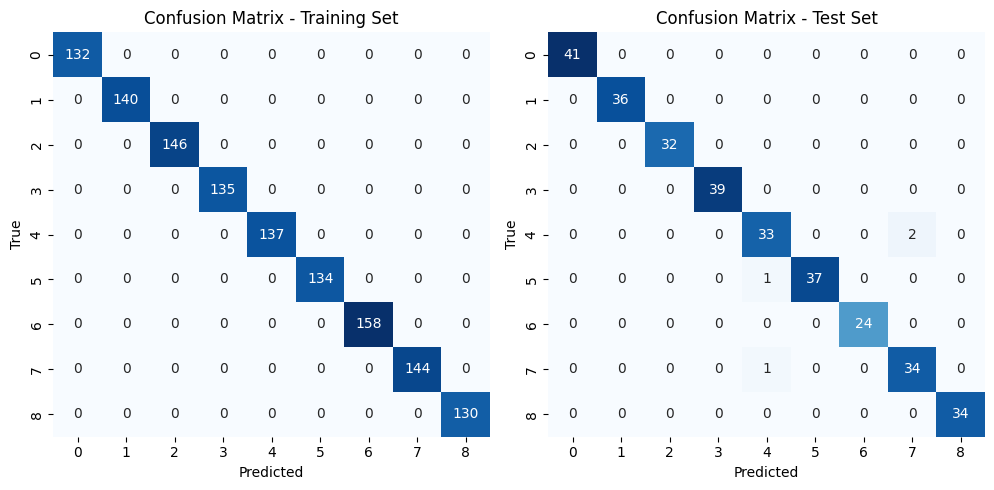

Deployment Duration: 0:08:29.218606


In [ ]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [ ]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 1.9002807	test: 1.8969568	best: 1.8969568 (0)	total: 64.6ms	remaining: 16.1s
10:	learn: 0.8399028	test: 0.8459617	best: 0.8459617 (10)	total: 596ms	remaining: 13s
20:	learn: 0.4760664	test: 0.4901450	best: 0.4901450 (20)	total: 1.16s	remaining: 12.6s
30:	learn: 0.3007493	test: 0.3189274	best: 0.3189274 (30)	total: 1.64s	remaining: 11.6s
40:	learn: 0.1966514	test: 0.2176968	best: 0.2176968 (40)	total: 2.15s	remaining: 10.9s
50:	learn: 0.1373123	test: 0.1619508	best: 0.1619508 (50)	total: 2.91s	remaining: 11.3s
60:	learn: 0.0985562	test: 0.1272256	best: 0.1272256 (60)	total: 3.48s	remaining: 10.8s
70:	learn: 0.0716618	test: 0.1030035	best: 0.1030035 (70)	total: 4s	remaining: 10.1s
80:	learn: 0.0557222	test: 0.0893200	best: 0.0893200 (80)	total: 4.54s	remaining: 9.46s
90:	learn: 0.0455970	test: 0.0814866	best: 0.0814866 (90)	total: 5s	remaining: 8.74s
100:	learn: 0.0397064	test: 0.0771441	best: 0.0771441 (100)	total: 5.61s	remaining: 8.27s
110:	learn: 0.0343032	test: 0.0733072	b